In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
!pip3 install feature-engine
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer
!pip3 install mlflow
import mlflow

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import ConfusionMatrixDisplay

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tk-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tk-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
import pandas as pd
df = pd.read_csv('train.csv')

In [4]:
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

/var/folders/30/0njqs3l10dnf4dblhpx1rqg80000gn/T/ipykernel_17696/2861725518.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
/var/folders/30/0njqs3l10dnf4dblhpx1rqg80000gn/T/ipykernel_17696/2861725518.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [5]:
 columns_to_drop = ['passengerid','name','ticket','cabin']

In [6]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
     .drop(columns=['sibsp','parch'])
    )

In [7]:
final_df = clean_data(df)

final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [8]:
(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def create_boxplot(data, column_name, title=None):
    sns.boxplot(y=column_name, data=data)
    if title:
        plt.title(title)
    plt.show()

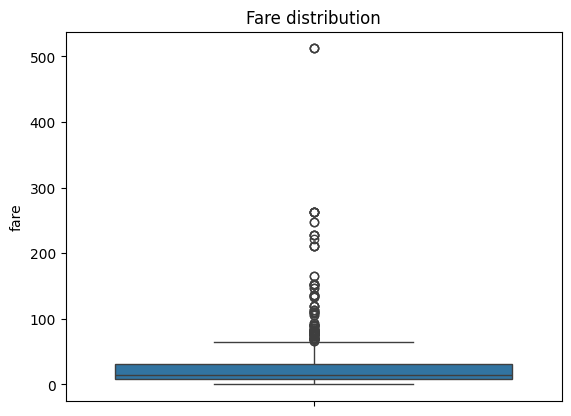

In [10]:
create_boxplot(final_df,'fare', title = 'Fare distribution')

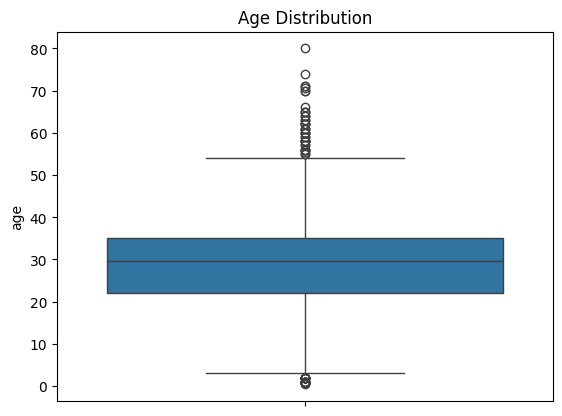

In [11]:
create_boxplot(final_df, 'age', title='Age Distribution')

In [12]:
def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

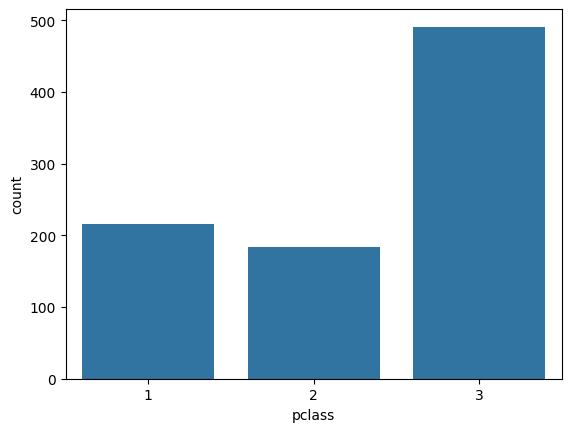

In [13]:
plot_distribution(final_df,'pclass')

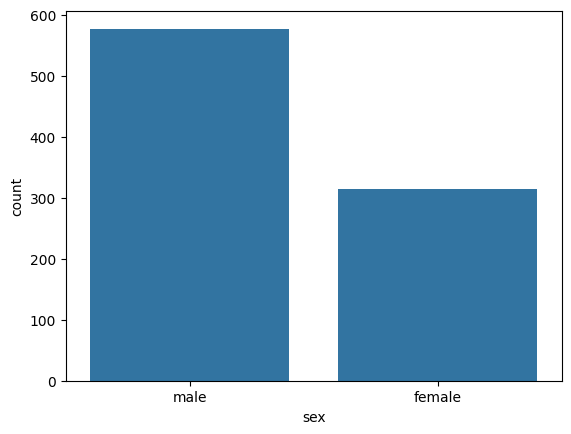

In [14]:
plot_distribution(final_df,'sex')

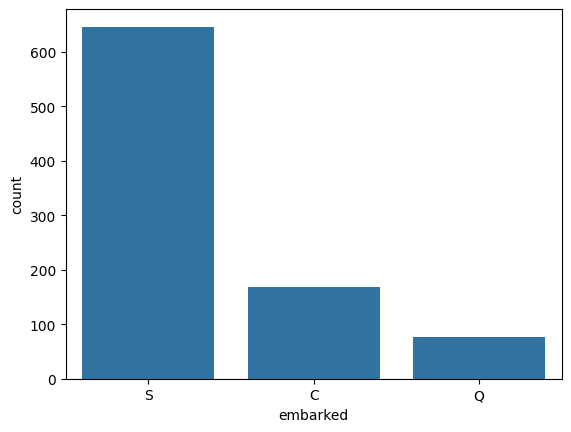

In [15]:
plot_distribution(final_df,'embarked')

In [16]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [17]:
X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [18]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print('The shape of training data is',X_train.shape)
print('The shape of testing data is',X_test.shape)

The shape of training data is (712, 6)
The shape of testing data is (179, 6)


In [20]:
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())
])
age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [21]:
fare_pipe = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [22]:
embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

# Column Transformer

In [23]:
set_config(transform_output='pandas')

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipe, ['age']),
    ('fare', fare_pipe, ['fare']),
    ('embarked', embarked_pipe, ['embarked']),
    ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
    ('family', MinMaxScaler(), ['family'])
], remainder='passthrough', n_jobs=1)
preprocessor

ColumnTransformer(n_jobs=1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [25]:
preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.241390,0.236751,1.0,0.0,1.0,0.0,1
733,-0.505110,-0.532339,1.0,0.0,1.0,0.0,2
382,0.193490,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.272244,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.824689,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.660355,-0.797799,1.0,1.0,0.0,0.0,3
270,0.014890,0.360798,1.0,0.0,1.0,0.0,1
860,0.892090,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.203711,2.016201,1.0,1.0,0.0,0.3,1


In [26]:
preprocessor.get_params()

{'n_jobs': 1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
 'fare': 

# Model **Pipeline**

In [78]:
# build the model pipeline
model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.3,
 'n_estimators': 300,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [79]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier(**model_params))
])
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        min_samples_split=3,
                                        min_weight_fraction_leaf=0.3,
                                        n_estimators=300, n_jobs=1,
                                        random_state=30))])

In [80]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        min_samples_split=3,
                                        min_weight_fraction_leaf=0.3,
                                        n_estimators=300, n_jobs=1,
                                        random_state=30))])

In [81]:
y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred).item()
recall = recall_score(y_test,y_pred).item()
f1 = f1_score(y_test,y_pred).item()

In [82]:
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

metrics

{'accuracy': 0.7821229050279329,
 'precision': 0.7536231884057971,
 'recall': 0.7027027027027027,
 'f1_score': 0.7272727272727273}

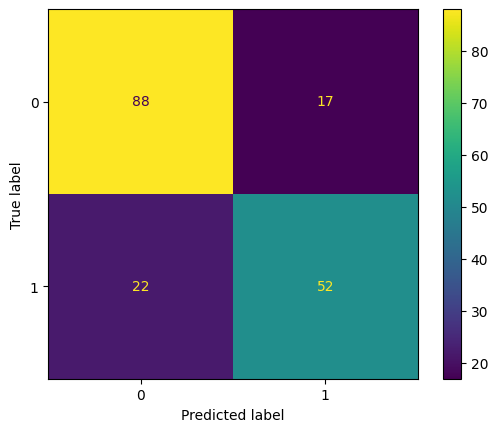

In [83]:
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# MLFLow Code Tracking

In [84]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(n_jobs=1, remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                                    ['fare']),
                                   (

In [96]:
mlflow.set_tracking_uri("http://127.0.0.1:8000")
mlflow.set_experiment("Titanic Data")

with mlflow.start_run() as run:
    data_signature = mlflow.models.infer_signature(model_input=X_train, model_output=model_pipe.predict(X_train))
    
    mlflow.log_params(model_pipe.get_params())
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(sk_model=model_pipe, artifact_path="model.pkl", signature=data_signature)
    
    model_uri = mlflow.get_artifact_uri("model.pkl")
    mlflow.log_figure(cm.figure_, artifact_file='confusion_matrix.png')
    
    # Save X_train to a CSV file before logging it
    X_train.to_csv("train.csv", index=False)
    mlflow.log_artifact("train.csv")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/09/21 17:43:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-kit-958 at: http://127.0.0.1:8000/#/experiments/448533719677936531/runs/2b48a3301f0d412aa0976e011476d784.
2024/09/21 17:43

In [86]:
import mlflow
logged_model = 'runs:/370376ed45294b1b876cf49b44109628/model.pkl'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1])